In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.spatial.qhull import QhullError
import seaborn as sns
from adjustText import adjust_text
import sklearn
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
url = 'https://raw.githubusercontent.com/sweis/whiskies/master/whiskies.txt'
df = pd.read_csv(url).drop(columns=['RowID','Postcode'])
df.head()

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Latitude,Longitude
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,286580,749680
1,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,326340,842570
2,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,352960,839320
3,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,141560,646220
4,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,355350,829140


In [0]:
coastline_fp = 'coastline.shp'
coastline = gpd.read_file(coastline_fp)
coastline.head()

In [0]:
mapper = DataFrameMapper([], default=StandardScaler())
train = df.drop(columns=['Distillery', 'Longitude', 'Latitude'])
X = mapper.fit_transform(train)
Z = PCA().fit_transform(X)

In [0]:
ap = AffinityPropagation(preference=-25).fit(Z)
kmeans = KMeans().fit(Z)

In [0]:
def plot(labels, names, x, y):
  sns.set()
  unique_labels = np.unique(labels)
  unique_dict = dict(zip(range(0, len(unique_labels)), unique_labels))
  #fig, ax = plt.subplots(figsize=(20,10))
  
  ax = coastline.plot(figsize=(30, 30), alpha=0.5, edgecolor='k')
  ax.set_ylim(530000, 1050000)
  ax.set_xlim(100000, 420000)
  cmap = cm.get_cmap('tab20b')
  palette = list(map(cmap, [(x/(unique_labels.max()+1)) for x in range(0, unique_labels.max()+1)]))
  colors = [palette[x] for x in labels]
  ax.scatter(x, y, c=colors, marker='o')  
  texts = []
  
  for i, txt in enumerate(names):
    texts.append(plt.text(x[i], y[i], txt, ha='center', va='center', c=colors[i]))
    #ax.annotate(txt, (x[i], y[i]), c=colors[i])
  adjust_text(texts)

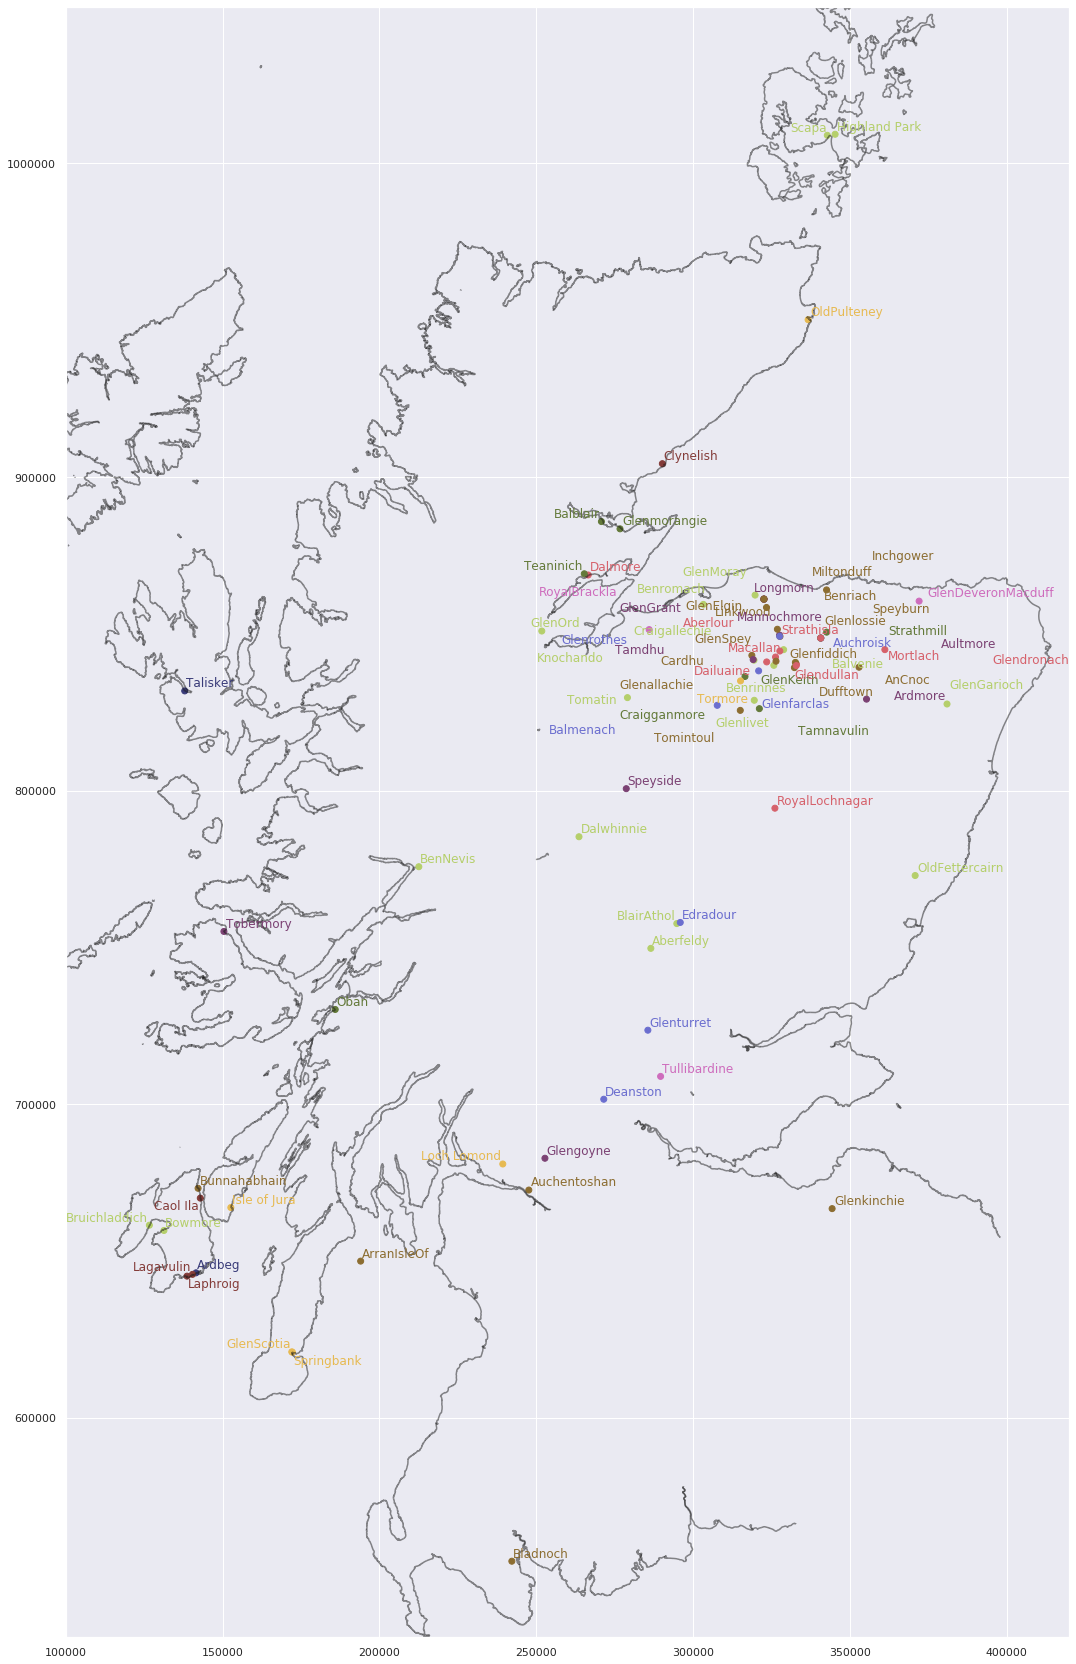

In [85]:
plot(ap.labels_, df['Distillery'], df['Latitude'], df['Longitude'])

In [10]:
unique_labels = np.unique(ap.labels_)
for i in unique_labels:
  cluster = df[i == ap.labels_].drop(columns=['Latitude', 'Longitude'])
  print("Cluster {}".format(i)),
  for d in cluster['Distillery'].values:
    print("\t{}".format(d))

  ['Talisker', 'Edradour', 'Oban', 'Glenlivet', 'Glenfiddich', 'Isle of Jura', 'Lagavulin', 'Macallan', 'Ardmore', 'Tullibardine']

Cluster 0
	Ardbeg
	Talisker
Cluster 1
	Auchroisk
	Balmenach
	Deanston
	Edradour
	Glenfarclas
	Glenrothes
	Glenturret
Cluster 2
	Balblair
	Craigganmore
	GlenKeith
	Glenmorangie
	Oban
	Strathmill
	Tamnavulin
	Teaninich
Cluster 3
	Aberfeldy
	Balvenie
	BenNevis
	Benrinnes
	Benromach
	BlairAthol
	Bowmore
	Bruichladdich
	Craigallechie
	Dalwhinnie
	GlenGarioch
	GlenMoray
	GlenOrd
	Glenlivet
	Highland Park
	Knochando
	OldFettercairn
	Scapa
	Tomatin
Cluster 4
	AnCnoc
	ArranIsleOf
	Auchentoshan
	Benriach
	Bladnoch
	Bunnahabhain
	Cardhu
	Dufftown
	GlenElgin
	GlenSpey
	Glenallachie
	Glenfiddich
	Glenkinchie
	Glenlossie
	Inchgower
	Linkwood
	Miltonduff
	Speyburn
	Tomintoul
Cluster 5
	GlenScotia
	Isle of Jura
	Loch Lomond
	OldPulteney
	Springbank
	Tormore
Cluster 6
	Caol Ila
	Clynelish
	Lagavulin
	Laphroig
Cluster 7
	Aberlour
	Dailuaine
	Dalmore
	Glendronach
	Glendullan
	Macallan
	Mortlach
	RoyalLochnagar
	Strathisla
Cluster 8
	Ardmore
	Aultmore
	GlenGrant
	Glengoyne
	Longmorn
	Mannochmore
	Speyside

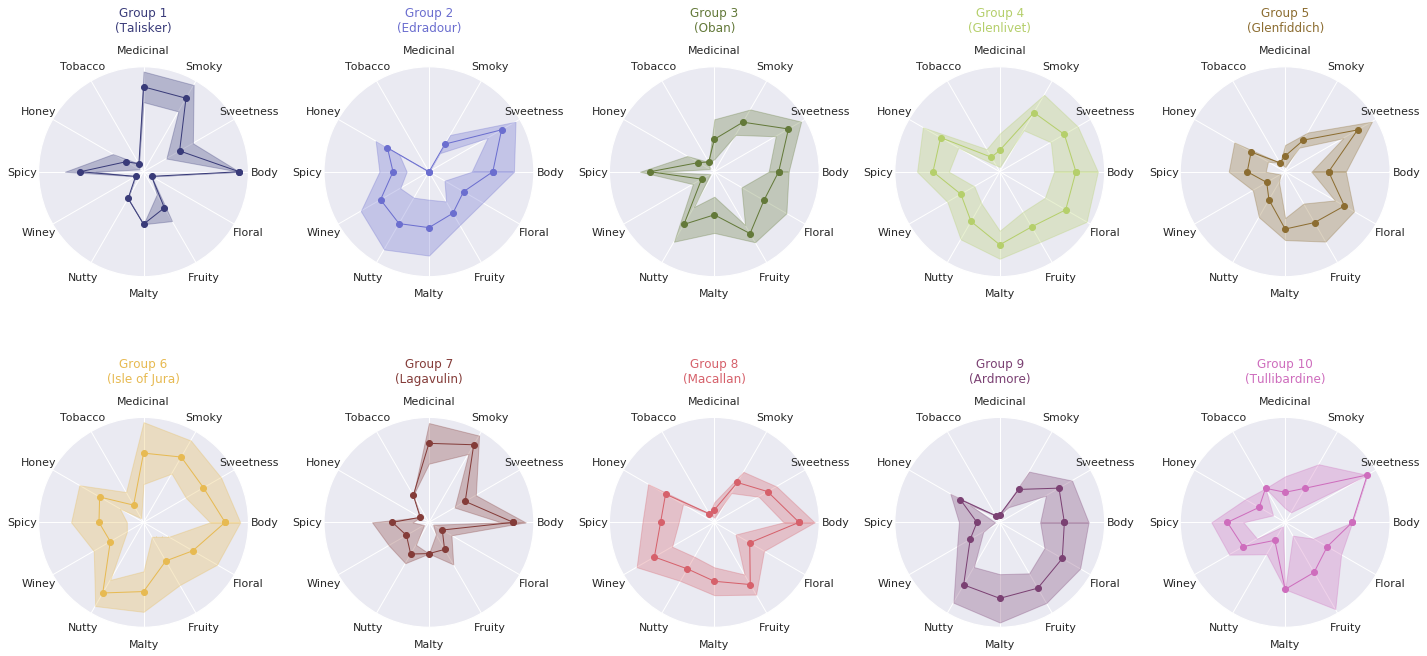

In [94]:
def make_radar_chart(ax, name, mean, std, attribute_labels, plot_markers, color):
    labels = np.array(attribute_labels)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    mean = np.concatenate((mean,[mean[0]]))
    std = np.concatenate((std,[std[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    ax.plot(angles, mean, 'o-', alpha=1, linewidth=1, c=color)
    ax.fill_between(angles, np.subtract(mean, std), np.add(mean, std), alpha=0.3, color=color)
    ax.set_yticks([])
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(name, c=color, loc='center', pad=25)
    ax.grid(True)

data = df.drop(columns=['Latitude', 'Longitude'])
unique_labels = np.unique(ap.labels_)
cmap = cm.get_cmap('tab20b')
palette = list(map(cmap, [(x/(unique_labels.max()+1)) for x in range(0, unique_labels.max()+1)]))
colors = [palette[x] for x in unique_labels]
labels = data.columns[1:]
markers = ["Low", "", "", "", "High"]
fig, axes = plt.subplots(2, 5, subplot_kw=dict(polar=True), figsize=(20,10), sharey=False, tight_layout=True)
representatives = ['Talisker', 'Edradour', 'Oban', 'Glenlivet', 'Glenfiddich', 
                   'Isle of Jura', 'Lagavulin', 'Macallan', 'Ardmore', 'Tullibardine']
for i in unique_labels:
  cluster = df[i == ap.labels_].drop(columns=['Latitude', 'Longitude'])
  desc = cluster.describe()
  mean = desc.T['mean'].values
  std = desc.T['std'].values
  row = int(i/5)
  col = i % 5
  make_radar_chart(axes[row][col], "Group {}\n({})".format(i+1,representatives[i]), mean, std, labels, markers, colors[i])

In [55]:
coastline_fp = 'coastline.shp'
coastline = gpd.read_file(coastline_fp)

,NATURAL,NAME,geometry
0,shoreline,None,"LINESTRING (8966.974 901122.706, 8938.891 9011..."
1,shoreline,None,"LINESTRING (8022.223 899867.790, 8027.677 8998..."
2,shoreline,None,"LINESTRING (11379.597 899344.735, 11361.302 89..."
3,shoreline,None,"LINESTRING (9883.599 897949.173, 9901.946 8979..."
4,shoreline,None,"LINESTRING (15248.978 906609.153, 15245.884 90..."


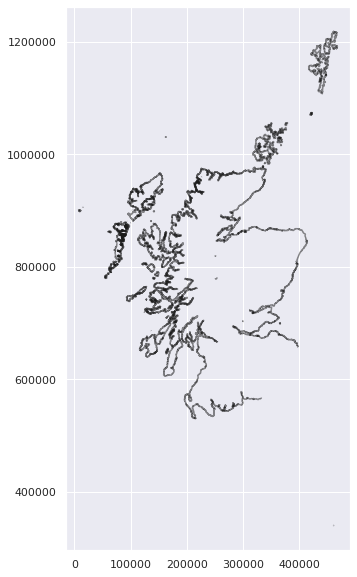

In [60]:
ax = coastline.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')


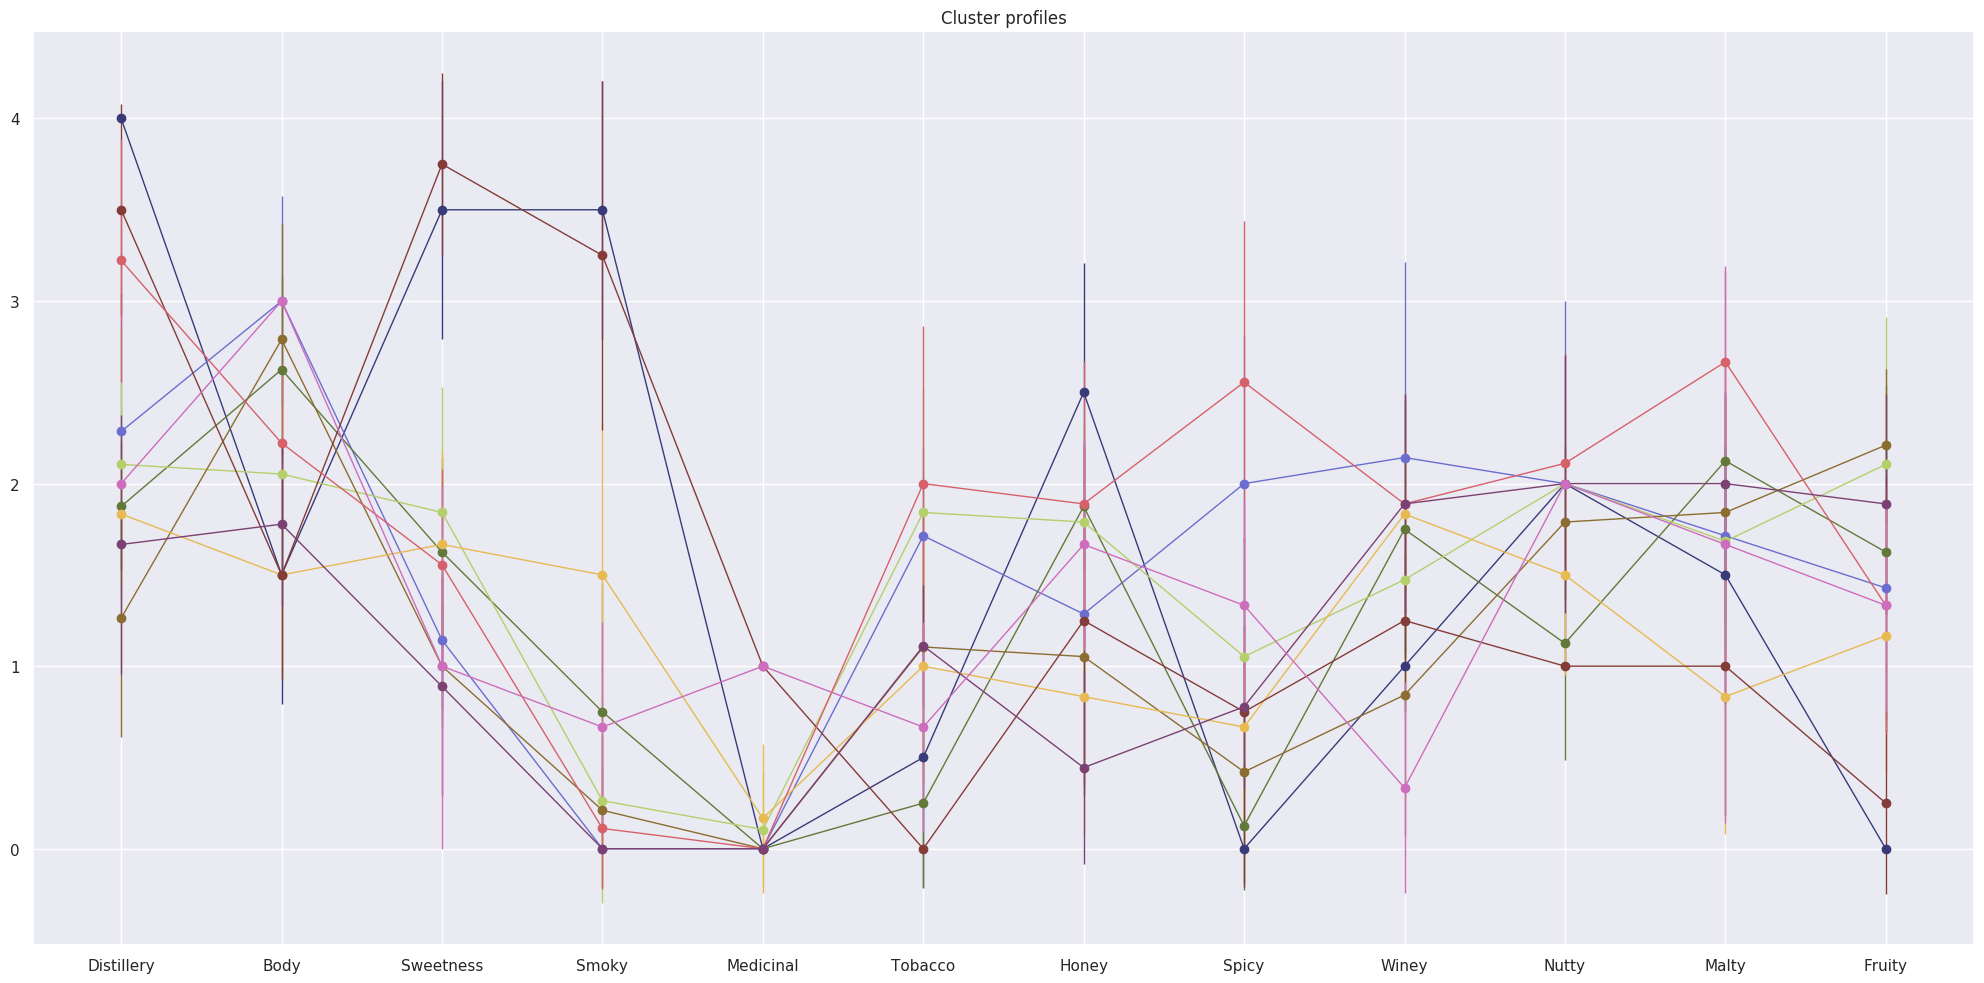

In [0]:
data = df.drop(columns=['Latitude', 'Longitude'])
unique_labels = np.unique(ap.labels_)

fig, axs = plt.subplots(figsize=(20,10), sharey=True, tight_layout=True)
xticks = np.arange(len(data.columns) - 1)
axs.set_xticklabels(data.columns)
axs.set_xticks(xticks)
axs.set_title("Cluster profiles")

cmap = cm.get_cmap('tab20b')
palette = list(map(cmap, [(x/(unique_labels.max()+1)) for x in range(0, unique_labels.max()+1)]))
colors = [palette[x] for x in unique_labels]

for i in unique_labels:
  cluster = df[i == ap.labels_].drop(columns=['Latitude', 'Longitude'])
  desc = cluster.describe()
  mins = desc.T['max'].values
  maxes = desc.T['min'].values
  means = desc.T['mean'].values
  std = desc.T['std'].values
  #axs[i].set_title("Cluster {}".format(i))
  axs.errorbar(xticks, means, std, marker='o', lw=1, alpha=1, c=colors[i])
  #axs.errorbar(xticks, means, [means - mins, maxes - means], marker='.', alpha=.2, lw=1, c=colors[i])
  

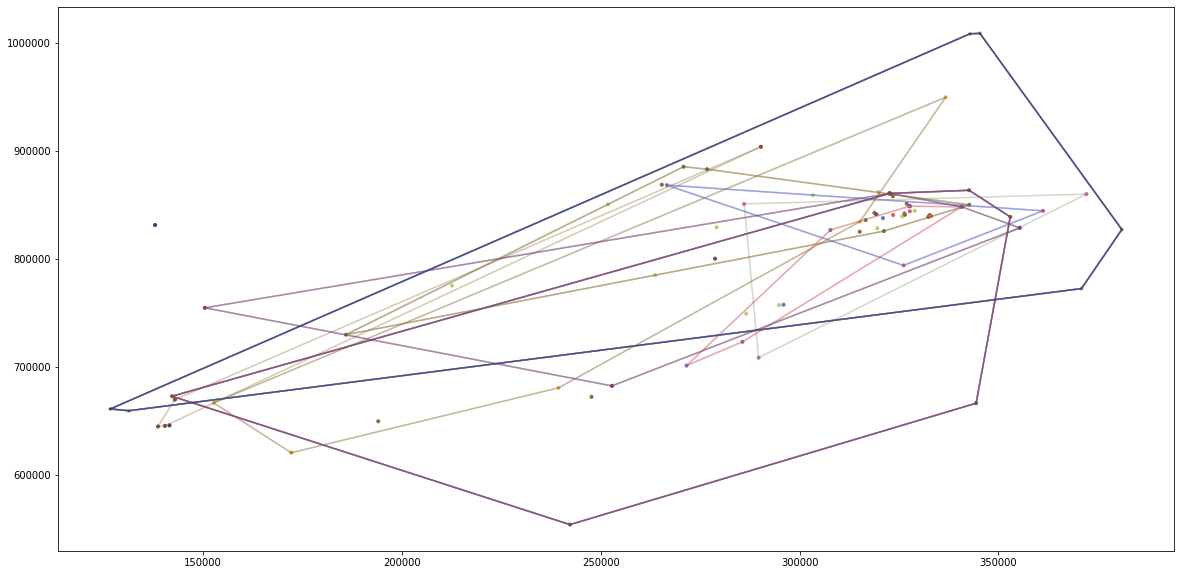

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
cmap = cm.get_cmap('tab20b')
palette = list(map(cmap, [(x/(np.unique(ap.labels_).max()+1)) for x in range(0, np.unique(ap.labels_).max()+1)]))
colors = [palette[x] for x in ap.labels_]
for i in ap.labels_:
    cluster = df[i == ap.labels_][['Longitude', 'Latitude']]
    try:
        hull = ConvexHull(cluster)
        for simplex in hull.simplices:
            start = cluster.iloc[simplex[0]]
            stop = cluster.iloc[simplex[1]]
            ax.plot([start[1], stop[1]], [start[0], stop[0]], c=colors[i], alpha=0.1)
    except QhullError:
        continue

ax.scatter(df['Latitude'], df['Longitude'], c=colors, marker='.')  